In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import time

start_date = '2020-03-01'
end_date ='2021-05-31'

a_qty = 20

a_fail_rate = .5

use_fail = False

unit_label = 'p/100m'

# survey data:
dfx= pd.read_csv('resources/checked_sdata_eos_2020_21.csv')

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description

# code material map
code_m_map = dfCodes.material

new_descriptions = { 'Industrial pellets (nurdles)': 'Pellets',
                    'Glass drink bottles, pieces': 'Glass bottles and pieces', 
                    'Food wrappers; candy, snacks': 'Food wrappers', 
                    'Food wrappers; candy, snacks': 'Food wrappers', 
                    'Foam packaging/insulation/polyurethane': 'Foam packaging for insulation', 
                    'Packaging films nonfood or unknown': 'Packaging films (not food-related)', 
                    'Lids unidentified': 'Other lids', 
                    'Tobacco; plastic packaging, containers': 'Plastic packaging for tobacco', 
                    'Fireworks paper tubes and fragments': 'Fireworks (paper parts)', 
                    'Diapers - wipes': 'Diapers and wipes', 
                    'Foamed items & pieces (non packaging/insulation) foamed sponge material': 'Foam items and pieces (not insulation)', 
                    'Labels, bar codes': 'Labels and bar codes', 
                    'Sanitary pads /panty liners/tampons and applicators': 'Sanitary pads, tampons and applicators', 
                    'Pellet mass from injection molding': 'Pellet mass', 
                    'Bags; plastic shopping/carrier/grocery and pieces': 'Plastic bags and pieces', 
                    'Lids for chemicals, detergents (non-food)': 'Lids for chemicals and detergents', 
                    'Coverings; plastic packaging, sheeting for protecting large cargo items': 'Plastic sheeting for large cargo items', 
                    'Construction material; bricks, pipes, cement': 'Construction materials (bricks, pipes, cement)', 
                    'Fireworks; rocket caps, exploded parts & packaging': 'Fireworks (rocket caps, exploded parts and packaging)', 
                    'Foamed EVA (flexible plastic) for crafts & watersports': 'Foamed EVA', 
                    'Metal bottle caps, lids & pull tabs from cans': 'Metal bottle caps, lids and pull tabs from cans', 
                    'Lid/cap rings from plastic bottles/containers': 'Lids and cap rings from plastic bottles', 
                    'Tissue, toilet paper, napkins, paper towels': 'Tissues, toilet paper and paper towels', 
                    'Cotton bud/swab sticks': 'Cotton buds and swab sticks', 
                    'Foil wrappers, aluminum foil': 'Aluminum foil', 
                    'Clothing, towels & rags': 'Clothing and rags', 
                    'Food containers single use foamed or plastic': 'Plastic food containers', 
                    'Plastic fragments angular <5mm': 'Angular plastic fragments (< 0.5 cm)', 
                    'Plastic fragments rounded <5mm': 'Round plastic fragments (< 0.5 cm)', 
                    'Foamed  plastic <5mm': 'Foam plastic (< 0.5 cm)', 
                    'Styrofoam < 5mm': 'Styrofoam fragments (< 0.5 cm)', 
                    'Glass or ceramic fragments > 2.5 cm': 'Glass and ceramic fragments (> 2.5 cm)',
                   }

to_replace = new_descriptions.keys()

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]


pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

new_label_keys = {
    1:"industrial",
    2:"buildings",
    3:"buildings",
    4:"buildings",
    5:"buildings",
    6:"transport",
    7:"transport",
    8:"transport",
    9:"buildings",
    10:"recreation",
    11:"agriculture",
    12:"agriculture",
    13:"agriculture",
    14:"agriculture",
    15:"agriculture",
    16:"agriculture",
    17:"woods",
    18:"agriculture",
    19:"woods",
    20:"woods",
    21:"woods",
    22:"woods",
    23:"water",
    24:"water",
    25:"unproductive",
    26:"unproductive",
    27:"unproductive"
}


def combineLandUseFeatures(buffer_data: pdtype = None, a_col: str = "AS18_27", new_col: str = "label",
                           new_label_keys: dict = new_label_keys) -> pdtype:
    """Assigns labels to land-use values according to <label_keys_new>. The new labels,
    when aggregated, create groups of land-use values that are similar. For exmaple,
    all the different types of buildings are labeled "buildings"
    
    Args:
        buffer_data: The land use values at a given radius
        a_col: The original column name that holds the labels for the land use values
        new_col: The new name of the column with the new labels
    
    Returns:
        The data frame with the new column and the new labels    
    """    
    
    buffer_data.rename(columns={"slug":"location", a_col:new_col}, inplace=True)
    buffer_data[new_col] = buffer_data[new_col].apply(lambda x : new_label_keys[x])
    
    return buffer_data

def adjustLandUse(buffer_data: pdtype = None, exclude_these: list = [], locations: list = []) -> pdtype:
    """The surface area of the water feature is removed from land-use calcluation. This
    can be bypassed. However, the study considers the surface area of the water as a fixed
    feature that exchanges with the different land-use features (which are not fixed).
    
    Args:
        buffer_data: The land use values at a given radius
        exclude_these: The labels to be excluded from the land use total
        locations: The locations of interest with buffer data
        
    Returns:
        The dataframe with the locations in locations and without the excluded labels      
    """
    data = buffer_data[~buffer_data.label.isin(exclude_these)]
    data = data[data.location.isin(locations)]
    
    return data

def addRoadLengthToBuffer(buffer_data: pdtype = None, location: str = None, 
                          road_lengths: pstype = None, scale: float = 1000.0):
    """Adds the length of road network to the % land use values.
    """
    
    road_length = road_lengths.loc[location]
    if scale != 1:
        road_length = round(road_length/scale, 1)
    
    buffer_data["roads"] = road_length
    
    return buffer_data

def addIntersectsToBuffer(buffer_data: pdtype = None, location: str = None, 
                          intersects: pstype = None, scale: float = 100.0):
    
    """Adds the number of river intersections to the buffer.
    
    The river intersections are the points where rivers join the body of water of interest
    """
    
    n_intersects = intersects.loc[location]
        
    buffer_data["intersects"] = n_intersects
    
    return buffer_data

def calculatePercentLandUse(buffer_data: pdtype = None, location: str = None, columns: list=[], label: str = "label",
                           add_intersects_roads: bool = True,  road_lengths: pstype = None, intersects: pstype = None) -> pd.Series:
    """Figures the % of total of each land-use feature for one location.
    
    Args:
        buffer_data: The land use values at a given radius
        location: The survey location of interest
    
    Returns:
        A pandas series of the % of total for each land-use feature in the index
    """
    
    try:
        # try to reitrieve the land use data for a location
        location_data = buffer_data[buffer_data.location == location][label].value_counts()
    except ValueError:
        print("The location data could not retrieved")
        raise
    
    # the sum of all land use features in the radius
    total = location_data.sum()
    # the amount of the area attributed to water (lakes and rivers)
    water = location_data.loc["water"]   
    # divide the land_use values by the total minus the amount attributed to water
    results = location_data/(total-water)
    results.fillna(0, inplace=True)
    
        
    
    # name the series
    results.name = location
    # the intersects and road-lengths are calculated seprately
    # if add_intersects and roads is true, attach them to the
    # the land use values
    if add_intersects_roads:
        results = addIntersectsToBuffer(buffer_data=results, location=location, intersects=intersects)
        results = addRoadLengthToBuffer(buffer_data=results, location=location, road_lengths=road_lengths)
    
    # add zero:
    zeros = [x for x in columns if x not in results.index]
    
    if len(zeros) > 0:
        
        for a_label in zeros:
            
            results.loc[a_label] = 0
    
    return results

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    def __init__(self, file_name: str = None, locations: list = [], columns: list={}):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        self.columns = columns
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, columns=self.columns, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse

# Lac Léman

This document details the methods used for the land use chapter of the IQAASL report. It has been expanded to include the supporting calculations for a manuscript based on the concepts initially introduced in the report. Before consulting the results of all the data it may be interesting to understand how these figures relate when the same methods are applied at a smaller scale, such as a lake. We offer two examples: Bielersee and Lac Léman.

The calculations are the same at each Geographic level. The number of samples and the mix of land-use attributes changes with every subset of data. It is those changes and how they relate to the magnitude of trash encountered that concerns these inquiries. This document assumes the reader knows what beach-litter monitoring is and how it applies to the health of the environment.

A statistical test is not a replacement for common sense. It is an another piece of evidence to consider along with the results from previous studies, the researchers personal experience as well as the history of the problem within the geographic constraints of the data.

## Introduction

To better control (eliminate) trash in the environment it is essential that the limited resources that are attributed to this domain be used as efficiently as possible. Correctly identifying zones of accumulation and or the objects that are accumulating in the watershed would enable more coordinated and precise actions between stakeholders. The process of identification needs to fulfill certain operating requirements to be effective:

* accurate
* repeatable
* scale-able (up and down)

Beach-litter data is `count` data. Gathered by volunteers following a protocol, the data is highly variable for many reasons. In most studies the median is less than the mean and in the case of the data for this study, the standard deviation is greater than the mean. Statistical tests dependent on linear relationships may not be appropriate, the guide from the JRC suggests using a Negative binomial distribution for modeling extreme events. Spearman's &rho; does not require that the two variables be continuous, nor is there an assumption of _normality_. The test is included in most standard computing libraries and spreadsheets, the process is easy to automate and integrate.  Spearman's &rho; or Spearman's rank correlation coefficient is a non parametric test of rank correlation between two variables. Spearmans &rho; defines the magnitude (how much it approaches linear) of monotonic relationships and the direction. When &rho; is 0 there is no evidence of a monotonic relationship. Values of 1 and -1 signify a perfect monotonic relationship between two variables.

__The hypothesis of &rho;__

$H_{0}$: There is no monotonic association between the two variables

Statistical significance is defined as a very unlikely outcome under the null hypothesis, for this report unlikely is defined as less than 5% chance or p < 0.05 that the null hypotheses will be rejected even though it is true. Spearmans &rho; is implemented using [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) on [Jupyter Lab](https://jupyter.org/) 

The data is beach litter data collected during a national survey of lakes and rivers in Switzerland, [IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/titlepage_de.html). Standard MSFD/OSPAR protocols were followed within geographic limitations.

__Using &rho;__

Land use data for each survey location was collected by creating buffer-zones around each survey location at radiuses from 1.5 - 5km and 10km and sectioning layers of the [Swiss Statistical Survey](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/land-use-cover-suitability/swiss-land-use-statistics.html#geodata__content_bfs_en_home_dienstleistungen_geostat_geodaten-bundesstatistik_boden-nutzung-bedeckung-eignung_arealstatistik-schweiz_jcr_content_par_tabs), the complete process is defined here [_The land use profile_](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.htmlwith).

The land use is designated For every 100m² of the country using satellite images. There are 27 different possible categories for each 100m², a buffer zone with radius of 1500m  has an area ( $\pi r^{2}$ ) of 7,068,583m² or $\approxeq$ 700 100m squares. In Switzerland the width of the lake shore is fairly small, a survey of 100m x 50m would be considered fairly large. For the data in this report the median survey length was 52 meters. 

However, there are over three hundred samples in the data set. Each sample has between zero and 100 different objects, each object has its own count. In total there were over 50,000 items collected, identified and counted in the 12 month period. Each sample is recorded as pieces of trash per meter and quantity. 

## Esitmating land-use

Once the data is exported from the maplayer the features were grouped by use. For example all types of buildings were grouped together, the different aggricultural uses were grouped together as well as woodlands and water features.

*__Below:__ The land use categories and the corresponding groups. Notice that `industrial` is the only group that has one land use component. The numbers in the square brackets are the original designation from the map layer. For example there were five different types of buildings desginated in the map layer* 
```python
    group_parts = {'buildings':[2,3,4,5,9],
                   'industrial':[1],              
                   'trans':[6,7,8],
                   'recreation':[10],
                   'agriculture':[11, 12, 13, 14, 15, 16, 18],
                   'woods':[17,19,20,21,22],
                   'water':[23,24],
                   'unproductive':[25,26,27]
                  }
```

### Estimating the road and river network

The values for the road and river network with a given radius are defined separately. The road network is the sum of the lengths of all roads, footpaths, freeways and forest roads within the area of interest. Note that the area attributed to roads given by the default map layer does not provide the same value. This is because of the way land use is estimated for each 100 m square. For example, if the center of a 100 m square has a road in it then the entire 100² m is attributed to the category roads (or railways). As a result only a portion of the road network is accounted for. 

To calculate the road network another map layer is used. The polylines for the roads are disolved into a single line, and the length of that line (divided by 1000) is the number of kilometers of road network for the area in question.

The river network, labeled as _intersections_ is only valid for lake samples. The intersections are the number of rivers/streams/canals that enter the lake within the given radius. Alternate methods (inlcuding length of the river network) are addressed in a later section. 

__The land use for one location: example @ 1500 m__

To calculate the land-use at one location for one radius. Requires indentifying the location of interest and the relevant file with the buffer data. These are minimum arguments to instantiate a `BufferData` object. Once the object is initiated the 

For each location an adjusted buffer object is created. An adjusted-buffer-object is a datafram with between 690-720 rows. Each row corresponds to the land-use attribution for one of the 100 m squares within the 1500 m radius. The aggregated groups are created when the object is iniated. The aggregation or grouping can be changed by replacing the `BufferData` default grouping dictionary with a new dictionary.

The adjusted-buffer object can be used to exclude columns or values that are not of interest. If no columns are excluded the adjusted-buffer object contains all the land-use attributes for the location in question.

*__Below:__ Creating a buffer object for one location and retrieving the % of land use for the defined categories* 
```python
# location of interest
location = "hauterive-petite-plage"

# the land-use values at a radius of 1500 m
file_name = "resources/buffer_output/luse_1500.csv"

# initiate a BufferData object
haut_rive_land_use = BufferData(file_name=file_name, locations=[location])

# call the method <percentLandUse> of the BufferData class
haut_rive_percent_land_use = haut_rive_land_use.percentLandUse()    
```

__The land use for more than one location: example @ 1500 m Lac Léman__

A correlation requires more than one set of values. To get the buffer data for a collection of locations, lets say a lake, suppy a list of locations to the `BufferData` class.

*__Below:__ Creating a buffer object for all the locations on a lake and retrieving the % of land use for the defined categories* 

```python
# all the locations on Lac Léman
locations = dfBeaches[dfBeaches.water_name_slug == 'lac-leman'].index

# use the same buffer data
file_name = "resources/buffer_output/luse_1500.csv"

# initiate a BufferData object
lac_leman_landuse = BufferData(file_name=file_name, locations=locations)

# call the method <percentLandUse> of the BufferData class
# calling T on the results puts the locations in the index and the land-use labels in the columns
neunburgersee_percent_land_use = lac_leman_landuse.percentLandUse().T
```

## Map of survey locations and aggregated results

```{figure} resources/images/lac-leman_city_labels.jpeg
---
name: 'leman-map'
---
` `
```
{numref}`figure %s: <leman-map>` The survey locations and aggregated municipal results.

In [2]:
locations = dfBeaches[dfBeaches.water_name_slug == 'lac-leman'].index
file_name = "resources/buffer_output/luse_1500.csv"
display_columns = ["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]
lac_leman_landuse = BufferData(file_name=file_name, locations=locations, columns=display_columns)
results = lac_leman_landuse.percentLandUse().T.round(3)

res = results[display_columns].style.format(precision=3).set_table_styles(table_css_styles)

glue("lac_leman_luse", res, display=False)

```{glue:figure} lac_leman_luse
---
name: 'lac_leman_luse'
---
` `
```
{numref}`figure %s: <lac_leman_luse>` The percent of total land-use attributed to each land use feature for each survey location on Lac Leman. __Intersects__ = the number of discharges within 1 500 m of the survey location. __Roads__ = the length of all roads, highways and pedestrian trails within 1500 m of the survey location.

## _&#929;_ for a collection of locations

Prior to calculating &rho; for a set of survey results there are some important considerations.

1. Does the hypothesis correspond to the requirements of the analysis?
2. How many samples are available?
3. Are the locations in the set of data related in some way?
4. Are the results normalized or standardized so that they are comparable?
5. What indications (if any) do the results suggest prior to conducting the test?

In our current use case the hypothesis (or the rejection of the null hypothesis) corresponds to our observations in the field for some objects. For example, it appears that more tobacco and snack related objects are found in greater density at locations that are in urban areas. Other objects, such as expanded polystyrene or fragmented plastics appear to be identified at more or less the same density indifferent of the survey location (there are a few exceptions).

The results are normalized to <i>number of objects per meter of shoreline (p/m)</i>. This allows the comparison of survey results between survey locations of different sizes. By normalizing the results and considering locations that have common elements (lake or river or catchment area) the number of samples can be maximized.

In cases of less than 500 samples a permutation test is conducted to calculate the null distribution of the statistic (the P value). [scipy spearmans](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)

__What about zero?__

It is necessary to include all samples, including those where none of the objects of interest were found. In the default data set each sample includes all the valid codes that could have been identified. If the surveyor did not enter any data for a particular code then the quantity of that code for that sample is automatically recorded as zero.

### Definition of codes of interest

The codes of interest are the objects for which we would like to determine a correlation. It is possible to just simply test all the codes for a set of survey results. However, running the tests on large data-sets can take time, and the generalization of any results is unreliable at best in the absence of supporting information.

In this document we have defined codes of interest as those codes that meet criteria based on quantity or frequency:

1. Consider only codes whose total quantity is above a certain threshhold
2. Consider only codes that were indentified (quantity > 0) in a certain number or ratio of samples 

*__Below:__ Using the fail rate or quantity to define the codes of interest.*

```python
# defining abundance and frequency
# create the feature data
# instantiate the survey results class
fdx = SurveyResults()

# call the survey results method with default arguments
df = fdx.surveyResults()

# define a threshold for the two parameters
abundance = 20
fail = .25

# abundance
codes = df.groupby("code").quantity.sum()
abundant = codes[codes > abundance].index

# frequency
codes_fail = df[df.quantity > 0].value_counts("code")/df.loc_date.nunique()
codes_fail = fail_rates[fail_rates > fail].index
```

### Ranked correlation of the most common objects on Lac Léman

To determine the ranked correlation of object density to land-use feature there are several steps that need to be accomplished. Some have been explained previously (`BufferData`, objects of interest). The goal is to compare the density of an object to a particular land use value. How this is achieved depends on your setup. For the data in this repo we use the following process:

1. Select a buffer radius 
2. Select a collection of related sample results
3. Construct buffer data
4. Format sample results
5. Indentify codes of interest
6. Make 2d array of code result and land use value ie. \[\[code_results\], \[land_use_%\]\] for each code and land-use attribute
7. Pass the 2d array to scipy.stats.spearmanr
8. Where samples are less than 500 run a permutation test for the null distribution

Classes and methods have been defined for each step click below to see the methods.

In [3]:
def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value

    return wrapper

def assignLanduseValue(sample: pstype=None, land_use: str=None) -> float:
    # returns the requested value of land use from the sample
    # if the requested land-use value is not present in the buffer
    # zero is returned
    try:
        result = sample.loc[land_use]
    except KeyError:
        result = 0
    
    return result

def cleanSurveyResults(data):
    # performs data cleaning operations on the
    # default data
    
    data['loc_date'] = list(zip(data.location, data["date"]))
    data['date'] = pd.to_datetime(data["date"])
    
    # get rid of microplastics
    mcr = data[data.groupname == "micro plastics (< 5mm)"].code.unique()
    
    # replace the bad code
    data.code = data.code.replace('G207', 'G208')
    data = data[~data.code.isin(mcr)]
    
    # walensee has no land-use values
    data = data[data.water_name_slug != 'walensee']   
    
    return data

class SurveyResults:
    """Creates a dataframe from a valid filename. Assigns the column names and defines a list of
    codes and locations that can be used in the CodeData class.
    """
    
    file_name = 'resources/checked_sdata_eos_2020_21.csv'
    columns_to_keep=[
        'loc_date',
        'location', 
        'river_bassin',
        'water_name_slug',
        'city',
        'w_t', 
        'intersects', 
        'code', 
        'pcs_m',
        'quantity'
    ]
        
    def __init__(self, data: str = file_name, clean_data: bool = True, columns: list = columns_to_keep, w_t: str = None):
        self.dfx = pd.read_csv(data)
        self.df_results = None
        self.locations = None
        self.valid_codes = None
        self.clean_data = clean_data
        self.columns = columns
        self.w_t = w_t
        
    def validCodes(self):
        # creates a list of unique code values for the data set    
        conditions = [
            isinstance(self.df_results, pdtype),
            "code" in self.df_results.columns
        ]

        if all(conditions):

            try:
                valid_codes = self.df_results.code.unique()
            except ValueError:
                print("There was an error retrieving the unique code names, self.df.code.unique() failed.")
                raise
            else:
                self.valid_codes = valid_codes
                
        
    def surveyResults(self):
        
        # if this method has been called already
        # return the result
        if self.df_results is not None:
            return self.df_results
        
        # for the default data self.clean data must be called        
        if self.clean_data is True:
            fd = cleanSurveyResults(self.dfx)
            
        # if the data is clean then if can be used directly
        else:
            fd = self.dfx
        
        # filter the data by the variable w_t
        if self.w_t is not None:
            fd = fd[fd.w_t == self.w_t]            
         
        # keep only the required columns
        if self.columns:
            fd = fd[self.columns]
        
        # assign the survey results to the class attribute
        self.df_results = fd
        
        # define the list of codes in this df
        self.validCodes()
        
        return self.df_results
    
    def surveyLocations(self):
        if self.locations is not None:
            return self.locations
        if self.df_results is not None:
            self.locations = self.dfResults.location.unique()
            return self.locations
        else:
            print("There is no survey data loaded")
            return None    

class BufferData:
    a_col="AS18_27"
    new_col = "label"
    exclude_these = []
    label_keys = new_label_keys
    beach_data = dfBeaches
    
    
    def __init__(self, file_name: str = None, locations: list = []):
        self.buffer = pd.read_csv(file_name)
        self.buffer_data = combineLandUseFeatures(buffer_data=self.buffer, a_col=self.a_col, new_col=self.new_col)
        self.adjusted_buffer = adjustLandUse(buffer_data=self.buffer_data, exclude_these=self.exclude_these, locations=locations)
        self.pctLandUse = None
        self.locations = locations
        
    def percentLandUse(self):
        
        if isinstance(self.pctLandUse, pdtype):
            return self.pctLandUse
        
        if isinstance(self.adjusted_buffer, pdtype):
            results = []
            road_lengths = self.beach_data.streets
            intersects = self.beach_data.intersects
            for location in self.locations:
                result = calculatePercentLandUse(buffer_data=self.adjusted_buffer, location=location, road_lengths=road_lengths, intersects=intersects)
                results.append(result)
        else:
            raise TypeError
            
        self.pctLandUse = pd.concat(results, axis=1)
        
        return self.pctLandUse
    
class CodeData:
    
    def __init__(self, data: pdtype = None, code: str = None, **kwargs):
                
        self.data = data
        self.code = code
        self.code_data = None       
    
    def makeCodeData(self)->pdtype:
        
        if isinstance(self.code_data, pdtype):
            return self.code_data        
        
        conditions = [
            isinstance(self.data, pdtype)            
        ]
        
        if all(conditions):
            self.code_data = self.data[self.data.code == self.code]
            return self.code_data    
    
class CodeResults:   
        
    def __init__(self, code_data: pdtype = None, buffer: pdtype = None, code: str = None, 
                 method: callable = stats.spearmanr, **kwargs):        
        
        self.code_data = code_data
        self.buffer = buffer
        self.code = code
        self.method = method
        self.y = None
        self.x = None
        super().__init__()
    
        
    def landuseValueForOneCondition(self, land_use: str = None, locations: list = None)-> (np.array, np.array):
        
        x = self.code_data.pcs_m.values      
        y = [self.buffer[x].loc[land_use] for x in self.code_data.location.values]
        self.x, self.y = x, np.array(y)
                
        return self.x, self.y
    
    def rhoForALAndUseCategory(self, x: np.ndarray = None, y: np.ndarray = None) -> (float, float):
        # returns the asymptotic results if ranking based method is used        
        c, p = self.method(x, y)
        return c, p
    
    def getRho(self, x: np.array = None)-> float:
        # assigns y from self        
        result = self.method(x, self.y)
                       
        return result.correlation            
        
    def exactPValueForRho(self)-> float:
        # perform a permutation test instead of relying on 
        # the asymptotic p-value. Only one of the two inputs 
        # needs to be shuffled.
        p = stats.permutation_test((self.x,) , self.getRho, permutation_type='pairings', n_resamples=1000)
        
        return p


def makeBufferObject(file_name: str = "resources/buffer_output/luse_1500.csv", buffer_locations: list = None) -> (pdtype, pdtype):
    # Makes a buffer object by calling the BufferData class
    # calls the percentLandUse method and fills Nan values
    # returns the buffer_data object and pct land use values
    
    buffer_data = BufferData(file_name=file_name, locations=buffer_locations)
    pct_vals = buffer_data.percentLandUse()
    pct_vals.fillna(0, inplace=True)
    
    return buffer_data, pct_vals

def asymptoticAndExactPvalues(data: pdtype = None, buffer: pdtype = None, code: 'str'=None, land_use: 'str'=None)-> dict:
    
    code_data = CodeData(data=data, code=code).makeCodeData()
    code_results = CodeResults(code_data=code_data, buffer=buffer)
    
    x, y = code_results.landuseValueForOneCondition(land_use=land_use)
    ci, pi = code_results.rhoForALAndUseCategory(x, y)
    px = code_results.exactPValueForRho()
    
    return {"code": code, "landuse": land_use, "a_symp": (round(pi, 3), ci), "exact": (round(px.pvalue, 3), px.statistic,)}

@timer
def rhoForOneBuffer(data: pdtype = None, buffer_file: str = "resources/buffer_output/luse_1500.csv", 
                    codes: list=None, land_use: list=None)->(list, pdtype, pdtype):
    
    buffer_locations = data.location.unique()
    new_buffer, buffer_vals = makeBufferObject(file_name=buffer_file, buffer_locations=buffer_locations)    
        
    rhovals_for_this_buffer = []
    for code in codes:
        for use in land_use:
            results = asymptoticAndExactPvalues(data=data, buffer=buffer_vals, code=code, land_use=use)
            rhovals_for_this_buffer.append(results)
    
    return rhovals_for_this_buffer, new_buffer, buffer_vals

def resultsDf(rhovals: pdtype = None, pvals: pdtype = None)-> pdtype:
    results_df = []
    for i, n in enumerate(pvals.index):
        arow_of_ps = pvals.iloc[i]
        p_fail = arow_of_ps[ arow_of_ps > 0.05]
        arow_of_rhos = rhovals.iloc[i]
        
        for label in p_fail.index:
            arow_of_rhos[label] = 0
        results_df.append(arow_of_rhos)
    
    return results_df

def rotateText(x):
    return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

def nObjectsPerLandUse(uses,surveys):
    results = {}
    for a_use in uses.index:
        total = surveys[surveys.code.isin(uses.loc[a_use])].quantity.sum()
        results.update({a_use:total})
    
    return pd.DataFrame(index=results.keys(), data=results.values(), columns=["total"])

To get the correlation coefficients for the data of interest call <i>rhoForOneBuffer</i> with the desired data, locations, the list of codes and the land-use attributes of interest:

```python
# collecting survey data
fdx = SurveyResults()
df = fdx.surveyResults()
# the locations on Neuchatel
df = df[df.location.isin(locations)]

# the land use features we are interested in
land_use =["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]

# codes of interest
# we are interested in objects that were found in 1/2 surveys
fail = .5

# calculate the frequency that each code was found
codes_fail = df[df.quantity > 0].value_counts("code")/df.loc_date.nunique()

# Only codes that were found in  at least .5 of all samples
codes_fail = codes_fail[codes_fail > fail].index

# identify the land_use data
buffer_file = "resources/buffer_output/luse_1500.csv"

# make the buffer and get the coeficients
rho_vals, new_buffer, buffer_vals = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)
``` 

The method returns an array of results (rho_vals), the buffer object (new_buffer) and the buffer values from the buffer object (buffer_vals) in %of total land use (example one). The aysmptotic and exact p value is calculated by default for each code and land-use attribute. The results stored in the rho_vals array can be turned into a dataframe. That dataframe contains the correlation coeficients and the p-values for all the requested code values and land attributes. Finally to display the value of the coeficients for those objects that have a p-value < 0.05 call resultsDF and provide as arugments one dataframe of the coeficients and one of the p-values.

*Example: displaying the objects and the correlation coeficients at each land-use attribute where p < 0.05. Note : 0.00 = p > 0.05 for that code and land attribute*

```python
# extracting the results of the correlation test from rho_vals
# this produces an array of dictionaries
buffer_results = [{"code":x["code"], "use": x["landuse"], "exact_p": x["exact"][0], "p": x["a_symp"][0], "rho": x["exact"][1]} for x in rho_vals]

# pass buffer values to the dataframe constructor
rho_at_buffer = pd.DataFrame(buffer_results)

# from the data frame create one each: data frame of p-values and rho-values
# slicing the p-values from the results dataframe
# Select "p" or "exact_p" depending on the number of samples
pvals = rho_at_buffer.pivot_table(index="code", columns="use", values="exact_p", aggfunc='first')
rhovals = rho_at_buffer.pivot_table(index="code", columns="use", values="rho", aggfunc='first').round(3)

# use the two dataframes as arguments to resultsDf and call the dataframe constructor on the return val
buffer_results = pd.DataFrame(resultsDf(rhovals, pvals))

# format for display
buffer_results.index.name = None
bfr = buffer_results.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=buffer_results.min().min(), vmax=buffer_results.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)
```    

In [4]:
# collecting survey data
fdx = SurveyResults()
df = fdx.surveyResults()
# the locations on Neuchatel
df = df[df.location.isin(locations)]

# the land use features we are interested in
land_use =["buildings",  "industrial", "roads", "recreation", "agriculture","woods", "intersects", "unproductive"]

# codes of interest
# we are interested in objects that were found in 1/2 surveys
fail = .5

# calculate the frequency that each code was found
codes_fail = df[df.quantity > 0].value_counts("code")/df.loc_date.nunique()

# Only codes that were found in  at least .5 of all samples
codes_fail = codes_fail[codes_fail > fail].index

# identify the land_use data
buffer_file = "resources/buffer_output/luse_1500.csv"

# make the buffer and get the coeficients
rho_vals, new_buffer, buffer_vals = rhoForOneBuffer(data=df, buffer_file=buffer_file , codes=codes_fail, land_use=land_use)

Finished 'rhoForOneBuffer' in 71.284 secs


In [5]:
buffer_results = [{"code":x["code"], "use": x["landuse"], "exact_p": x["exact"][0], "p": x["a_symp"][0], "rho": x["exact"][1]} for x in rho_vals]
rho_at_buffer = pd.DataFrame(buffer_results)
    
pvals = rho_at_buffer.pivot_table(index="code", columns="use", values="exact_p", aggfunc='first')
rhovals = rho_at_buffer.pivot_table(index="code", columns="use", values="rho", aggfunc='first').round(3)

buffer_results = pd.DataFrame(resultsDf(rhovals, pvals))
buffer_results.columns.name = None
bfr = buffer_results.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=buffer_results.min().min(), vmax=buffer_results.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)

glue("leman_rho_results", bfr, display=False)

```{glue:figure} leman_rho_results
---
name: 'leman_rho_results'
---
` `
```
{numref}`figure %s: <leman_rho_results>` The corelation coeficient of trash density to land-use features for Lac Léman. Coeffecients of 0 indicate that there is no statistical indication that the land use feature has an effect (positive or negative) on the trash density.

## Covariance of explanatory variables

The land-use attributes, considered here as independent variables, are also co-related. For example, the length of the road network in relation to the surface are attributed to buildings. For this analyis we should see similar results for co-related attributes (positive or negative). Most importantly, the assumed co-relation should make sense. Or, this may be casue for further investigation, indicating that the relationship is probably not well understood.  

In [6]:
buffer_percents = buffer_vals.T
buffer_percents = buffer_percents[land_use]
rho = buffer_percents.corr(method='spearman')
pval = buffer_percents.corr(method=lambda x, y: stats.spearmanr(x, y)[1])
pless = pd.DataFrame(resultsDf(rho, pval))

pless.columns.name = None
bfr = pless.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=rho.min().min(), vmax=rho.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)
bfr

,buildings,industrial,roads,recreation,agriculture,woods,intersects,unproductive
buildings,0.00,0.00,0.43,0.00,-0.66,-0.77,0.00,-0.45
industrial,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
roads,0.43,0.00,0.00,0.63,-0.63,-0.59,0.00,0.00
recreation,0.00,0.00,0.63,0.00,-0.42,0.00,-0.62,0.00
agriculture,-0.66,0.00,-0.63,-0.42,0.00,0.76,0.00,0.41
woods,-0.77,0.00,-0.59,0.00,0.76,0.00,0.00,0.55
intersects,0.00,0.00,0.00,-0.62,0.00,0.00,0.00,0.00
unproductive,-0.45,0.00,0.00,0.00,0.41,0.55,0.00,0.00


## Total correlations, total positive correlations and total negative corrrelations

The total correlations for a land-use attribute, (when considered with the attribute corelation table above) is an indication of the variety of objects that may be encountered at a suvey. 

In [7]:
def countTheNumberOfCorrelationsPerBuffer(pvals: pdtype = None, rhovals: pdtype = None) -> (pdtype, pstype):
    
    # the number of times p <= 0.05
    number_p_less_than = (pvals <= 0.05).sum()
    number_p_less_than.name = "correlated"
    
    # the number of postive correlations
    number_pos = (rhovals > 0).sum()
    number_pos.name = "positive"
    
    # the number of negative correlations
    number_neg = (rhovals < 0).sum()
    number_neg.name = "negative"

    ncorrelated = pd.DataFrame([number_p_less_than, number_pos, number_neg])
    ncorrelated["total"] = ncorrelated.sum(axis=1)
    
    return ncorrelated, ncorrelated.total

ncorrelated, total = countTheNumberOfCorrelationsPerBuffer(pvals, rhovals)
ncorrelated

,agriculture,buildings,industrial,intersects,recreation,roads,unproductive,woods,total
correlated,4,15,2,13,15,17,18,14,98
positive,1,0,2,12,2,2,16,11,46
negative,3,15,0,1,13,15,2,3,52


### Sum of the total number of objects with a correlation (positive or negative) collected under the different land use categories

The number of objects correlated is an indication of how much of the trash could be accounted for given the thresholds used for abundance or fail rate.

In [8]:
def numberOfObjectsCorrelatedPerAttribute(rho_at_buffer: pdtype = None, df: pdtype = None) -> pdtype:
    
    # select all the codes that have a p-value less than 0.05
    p_less_than = rho_at_buffer[rho_at_buffer.exact_p <= 0.05]

    # group the codes by land use attribute
    p_less_than_use_codes = p_less_than.groupby("use").code.unique()

    # sume the number of objects with a correlation (positive or negative) for each land use attribute
    results = nObjectsPerLandUse(p_less_than_use_codes,df)
    
    return results

numberOfObjectsCorrelatedPerAttribute(rho_at_buffer, df)

,total
agriculture,3276
buildings,14182
industrial,4174
intersects,7923
recreation,12205
roads,13904
unproductive,15855
woods,11998


## The objects of interest

Setting a threshold value for the dependent variable implies that we will not be using all the records availble. The threshold value defining the objects of interest was a fail rate >= 1/2. Which means that at least one out two samples will have a quantity > 0. 

### The % total of materials of the objects of interest with respect to the total number of objects collected.

In [9]:
def thePercentTotalOfMaterials(codes, df, materialmap):
    
    total = df.quantity.sum()
    buffer_codes = df[df.code.isin(codes)].copy()
    buffer_codes["material"] = buffer_codes.code.apply(lambda x: materialmap[x])
    
    material_df = pd.DataFrame(buffer_codes.groupby("material").quantity.sum()/total).round(3)
    
    material_df["quantity"] = material_df.quantity.apply(lambda x: f'{int((x*100))}%')
    
    return material_df

thePercentTotalOfMaterials(codes_fail, df, code_m_map)

,quantity
material,
Glass,2%
Metal,2%
Plastic,79%


### The % total of the top 10 objects with respect to all objects collected.

In [10]:
def thePercentTotalOfTheTopXObjects(df, x):
    index = [f'ratio of top {x} items over all items:',f'number of top {x} items:']
    item_totals = df.groupby("code").quantity.sum().sort_values(ascending=False)
    top_x = item_totals[:x].sum()
    total = df.quantity.sum()
    data = [f"{(round((top_x /total)*100))}%","{:,}".format(round(top_x))]
    return pd.DataFrame(data=data, index=index, columns=["value"])

thePercentTotalOfTheTopXObjects(df, 10)

,value
ratio of top 10 items over all items:,71%
number of top 10 items:,"17,394"


### The cumulative totals of the top 20 objects, grouped by economic source

/tmp/ipykernel_90066/725749272.py:61: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for ha in ax.legend_.legendHandles:


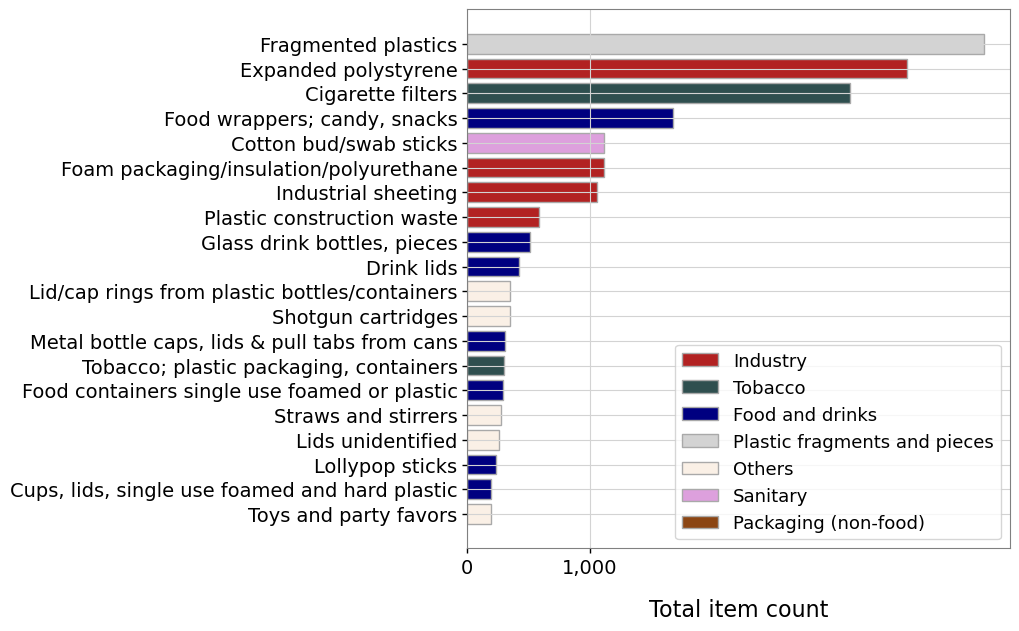

In [11]:
def check_condition(x, conditions, i):
    
    if list(set(x)&set(conditions[i])):
        data = conditions[i][0]        
    elif i == 0 and not list(set(x)&set(conditions[i])):
        data = "Others"    
    else:
        data = check_condition(x, conditions, i-1)
    return data

# define the broad categories:
tobaco = ["Tobacco", "Smoking related"]
industry = ['Industry','Construction', 'Industrial', 'Manufacturing']
sanitary = ["Sanitary", "Personal hygiene", "Water treatment"]
packaging = ['Packaging (non-food)','Packaging films nonfood or unknown', 'Paper packaging']
food = ['Food and drinks','Foil wrappers, aluminum foil', 'Food and drinks', 'Food and drink']
fragments = ['Plastic fragments and pieces',
             'Plastic fragments angular <5mm',
             'Styrofoam < 5mm', 
             'Plastic fragments rounded <5mm',
             'Foamed  plastic <5mm',
             'Fragmented plastics',
            ]

conditions = [tobaco, industry, sanitary, packaging, food, fragments]

dT20 = df.groupby("code", as_index=False).quantity.sum().sort_values("quantity", ascending=False)
dT20["description"] = dT20.code.map(lambda x: code_d_map[x])
dT20.set_index("code", drop=True, inplace=True)
dT20 = dT20.iloc[:20,:]
    
for each_code in dT20.index:
    srcs = dfCodes.loc[each_code][["source", "source_two", "source_three", "description"]]
    a = check_condition(srcs.values, conditions, len(conditions)-1)
    dT20.loc[each_code, "Type"] = a

fig, ax = plt.subplots(figsize=(7,7))
colors = {'Industry': 'firebrick', 'Tobacco': 'darkslategrey', 'Food and drinks': 'navy', 'Plastic fragments and pieces':'lightgrey',
         'Others':'linen','Sanitary':'plum','Packaging (non-food)':'saddlebrown'}

width = 0.6

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax.barh(dT20.description, dT20.quantity, color=[colors[i] for i in dT20.Type], edgecolor='darkgrey')
ax.invert_yaxis()  
ax.set_ylabel('')
ax.set_xticks([0,1000])
ax.set_xticklabels([0,'1,000'])

ax.set_xlabel('Total item count', fontsize=16, labelpad =15)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')
ax.set_facecolor('white')

plt.legend(handles, labels, fontsize=13,facecolor='white', loc="lower right")
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("darkgrey")

plt.grid(True)
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')

plt.show()

#### Litter items of local origin

Items that have four or more positive associations with a land use category.

In [12]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
local = correlated.code.value_counts()
local = local[local >= 4]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
code,,
G67,4,1058


#### Ubiquitous items

Items that have three or less positive associations with a land use category and are positively associated with river or stream intersections.

In [13]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
pos_intersects = rho_at_buffer[(rho_at_buffer.use == "intersects") & (rho_at_buffer.exact_p <= 0.05)]
correlated = correlated[correlated.code.isin(pos_intersects.code.unique())]
local = correlated.code.value_counts()
local = local[local <= 3]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
code,,
Gfoam,3,3586
G89,3,584
G32,3,192
G23,3,262
G33,3,196
G21,3,425
G70,3,345
G10,3,288
G35,2,278


#### Other items

Items that have three or less positive associations with a land use category and are NOT positively associated with river or stream intersections.

In [14]:
correlated = rho_at_buffer[(rho_at_buffer.exact_p <= 0.05) & (rho_at_buffer.rho > 0)]
pos_intersects = rho_at_buffer[(rho_at_buffer.use == "intersects") & (rho_at_buffer.exact_p > 0.05)]
correlated = correlated[correlated.code.isin(pos_intersects.code.unique())]
local = correlated.code.value_counts()
local = local[local <= 3]
local.name = "correlations"
quantity = df[df.code.isin(local.index)].groupby("code").quantity.sum()
items_of_local_origin = pd.DataFrame([local, quantity]).T
items_of_local_origin

,correlations,quantity
code,,
G95,3,1112
G27,2,3116
G24,2,349
Gfrags,1,4212
G30,1,1679
G178,1,308
G100,1,176


In [15]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 07/04/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [16]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: addwatermark

scipy     : 1.10.1
numpy     : 1.24.2
pandas    : 2.0.0
PIL       : 9.5.0
json      : 2.0.9
seaborn   : 0.12.2
matplotlib: 3.7.1
IPython   : 8.12.0

